In [1]:
import sys
sys.path.append('..')
import gdspy
import numpy as np
from importlib import reload
#import libraries.conformal_mapping as cm
#import libraries.general_design_functions as gdf
#import libraries.general_sample_creator as creator
#from  ..libraries import general_design_functions as gdf
#fr
from copy import deepcopy
from QCreator import elements
from QCreator import general_sample_creator as creator

In [2]:
tl_core = 20.
tl_gap = 12.
tl_ground = 10.

resonator_core = 8
resonator_gap = 7
resonator_ground = 16

pad_offset = 1000
pad_element_offset = 1000

coupler_start = pad_offset + pad_element_offset
coupler_delta = 500
coupler_length = 300
num_couplers = 1

# Transmission line with resonator (failed version)

In [3]:
reload(gdspy)
reload(creator)
reload(elements)

layers_configuration = {
    'total':0,
    'restricted area':10,
    'for removing':100,
    'JJs':1,
    'air bridges':2,
    'air bridge pads':3,
    'vertical gridlines':15,
    'horizontal gridlines':16
}
sample = creator.Sample('4_qubits',layers_configuration)

#specify sample vertical and horizontal lengths
sample.chip_geometry.sample_vertical_size=4.7e3
sample.chip_geometry.sample_horizontal_size=9.7e3

central_line_y = sample.chip_geometry.sample_vertical_size/2

ChichkovAB = elements.AirBridge(width=15, 
                                length=60, 
                                padsize=30, 
                                min_spacing = 30,
                                layer_configuration=sample.layer_configuration)

chip_edge_ground = elements.ChipEdgeGround(sample.chip_geometry, sample.layer_configuration, sample.pads)
sample.add(chip_edge_ground)

grid_ground = elements.GridGround(sample.chip_geometry, sample.layer_configuration, sample.objects, 
                                  width=4, period=500)
sample.add(grid_ground)

# 1. Create contact pads:

p1 = elements.Pad('p1', (pad_offset,  central_line_y), np.pi, tl_core, tl_gap, tl_ground, 
                  layer_configuration=sample.layer_configuration, chip_geometry=sample.chip_geometry, 
                  **elements.default_pad_geometry())
p2 = elements.Pad('p2', (sample.chip_geometry.sample_horizontal_size-pad_offset,  central_line_y), 
                  0, tl_core, tl_gap, tl_ground, 
                  layer_configuration=sample.layer_configuration, chip_geometry=sample.chip_geometry, 
                  **elements.default_pad_geometry())
sample.add(p1)
sample.add(p2)

# 2. Create main copler:

main_coupler = elements.CPWCoupler('TL-resonator coupler', [(coupler_start, central_line_y), 
                                                            (coupler_start+coupler_length, central_line_y)],
                                   w=[resonator_core, resonator_ground, tl_core],
                                   s=[resonator_gap,resonator_gap, tl_gap,tl_gap],
                                   g=tl_ground, 
                                   layer_configuration = sample.layer_configuration, r=100)
sample.add(main_coupler)

# # 3. Create fanout to create closed enfd of resonator
fanout_for_closed_end = sample.fanout(o=main_coupler, port='port1', name='closed end resonator fanout', grouping=[1,3])
# есть 3 группы проводов, часть идет наверх, часть вправо, часть влево, grouping=[a,b],провода младшеравно а идут наверх,
# провода старшеравно b идут вниз, меньше остаются на месте.
# # 4. 
g1 = sample.ground(o=fanout_for_closed_end, port='center', name='cl1', grounding_width=10, grounding_between = [(2,3)])
# эта функция добавляет закоротку к проводам в фанаут, они пишутся парами

# 5. Create left part of transmission line
left_TL = sample.connect_cpw(o1=p1, o2=g1, port1='port', port2='narrow', name='left TL', points=[])

# 6. Create closed meander of resonator
closed_end_meander = sample.connect_meander(name='closed end', o1=fanout_for_closed_end, port1='up',
                                            meander_length=2300,restricted_scale=400, constant_scale=900, radius=40)

# 7. Create fanout to create closed enfd of resonator
fanout_for_open_end = sample.fanout(o=main_coupler, port='port2', name='open end resonator fanout', grouping=[1, 3])

# 8. 
g2 = sample.ground(o=fanout_for_open_end, port='center', name='cl2', grounding_width=10, grounding_between = [(0,1)])

# 9. Create left part of transmission line
right_TL = sample.connect_cpw(o1=p2, o2=g2, port1='port', port2='narrow', name='right TL', points=[])

# # 10. Create closed meander of resonator
# open_end_resonator = elements.CPW(name='open end resonator', points=[fanout_for_open_end.get_terminals()['down'].position, (fanout_for_open_end.get_terminals()['down'].position[0],
#                                                                                                                     fanout_for_open_end.get_terminals()['down'].position[1]-1000)],
#                                   w=fanout_for_open_end.get_terminals()['down'].w, s=fanout_for_open_end.get_terminals()['down'].s,
#                                   g=fanout_for_open_end.get_terminals()['down'].g, layer_configuration=sample.layer_configuration, r=25)
# sample.add(open_end_resonator)
# sample.connections.append(((fanout_for_open_end, 'down', 0), (open_end_resonator, 'port1', 0)))


# 11. Create grounding of resonator
resonator_ground_ = sample.ground(o=closed_end_meander, port='port2', name='resonator ground', grounding_width=30, grounding_between = [(0,2)])

# add coaxmons
shift=-1/10
phi1=1/5
Couplers2q=[elements.coaxmon.CoaxmonCoupler(arc_start=-1/6-1/100+shift,arc_finish=-3/6+1/100+shift,phi=-1/2,
                                          coupler_type= 'coupler', w =10,g=10),
          elements.coaxmon.CoaxmonCoupler(arc_start=1/6+1/100+shift,arc_finish=3/6-1/100+shift,phi=phi1,
                                          coupler_type='coupler', w =8,g=10,s=7),# for resonator
          elements.coaxmon.CoaxmonCoupler(arc_start=3/6+1/100+shift,arc_finish=5/6-1/100+shift,phi=1/2, 
                                          coupler_type=None, w =8,g=10,s=7), #one upper
          elements.coaxmon.CoaxmonCoupler(arc_start=-1/6+1/100+1+shift,arc_finish=1/6-1/100+1+shift,phi=1,
                                          coupler_type=None, w =10),
          elements.coaxmon.CoaxmonCoupler(arc_start=-1/6+1/100+shift,arc_finish=1/6-1/100+shift,phi=0,
                                          coupler_type=None, w =10,g=40),
          elements.coaxmon.CoaxmonCoupler(arc_start=-5/6+1/100+shift,arc_finish=-3/6-1/100+shift,phi=1,
                                          coupler_type='grounded',w=4,g=4)
]


jj_coaxmon = {'a1':30,
               'b1':0.8,
               'a2':0.45,
               'b2':0.243,
               'c1':0.243,
               'c2':10,
               'angle_qubit':-np.pi/2-np.pi/3,
               'angle_JJ': 0,
               'length':10,
               'width':4}
# add coaxmons 1st line
coaxmon= elements.coaxmon.Coaxmon(name='Coaxmon',center=(1750+1000*0+700,1750-500),
                          center_radius = 100,
                          inner_couplers_radius = 140,
                          outer_couplers_radius = 200,
                          inner_ground_radius = 230,
                          outer_ground_radius = 250,
                          layer_configuration = sample.layer_configuration,
                          Couplers=Couplers2q,jj_params= jj_coaxmon,transformations={},
                          calculate_capacitance = True)

sample.add(coaxmon)
design = sample.draw_design()
end_element = coaxmon
end_port = 'coupler1'
end_element_position = end_element.get_terminals()[end_port].position
start_element = fanout_for_open_end
start_port = 'down'
start_element_position = start_element.get_terminals()[start_port].position
sample.connect_cpw(end_element, start_element, end_port, start_port, 'left resonator end', 
                  sample.cpw_shift(end_element,end_port,-100)+\
                   sample.cpw_shift(start_element,start_port,-200)
                  )
sample.draw_design()

E:\py38\lib\site-packages\gdspy\path.py:827: UserWarning: [GDSPY] Possible inconsistency found in `FlexPath` due to sharp corner.
  warnings.warn(


In [4]:
sample.qubits[0].get_terminals()

{'coupler0': Type: cpw, Position: (2450.0, 1020.0), Orientation: 1.571
 w: 10, s: None, g: 10
 reversed: True,
 'coupler1': Type: cpw, Position: (2636.074, 1385.191), Orientation: 3.77
 w: 8, s: 7, g: 10
 reversed: True,
 'coupler2': None,
 'coupler3': None,
 'coupler4': None,
 'flux line': Type: cpw, Position: (2274.962, 1072.905), Orientation: -2.35
 w: 4, s: 4, g: 4
 reversed: True,
 'qubit': None}

In [12]:
sample.watch()

In [6]:
sample.draw_cap()

In [7]:
sample.calculate_qubit_capacitance(cell= sample.qubit_cap_cells[0], qubit=sample.qubits[0],
                                   mesh_volume=20)

Gds file has been writen here:  E:\Github2.0\QCreator\example_notebooks\4_qubits.gds
For 0 conductor total length is:  6274
For 1 conductor total length is:  2503
For 2 conductor total length is:  821
For 3 conductor total length is:  806
Sum : 10404
Data has been written into the file: E:\Github2.0\QCreator\example_notebooks\mesh_4k_data
Time for fastcap job is:  0.9883558750152588
Capacitance results have been writen here:  E:\Github2.0\QCreator\example_notebooks\mesh_4k_results
Capacitance value in:  femtofarads


,0,1,2,3
0,170.7,-37.2,-26.5,-26.3
1,-37.2,64.6,-7.1,-7.0
2,-26.5,-7.1,41.0,-0.4
3,-26.3,-7.0,-0.4,40.8


In [20]:
1/np.sqrt(sample.qubits[0].L*sample.qubits[0].C['qubit']*1e-15)/2/np.pi/1e9

8.841941282883075

In [18]:
sample.qubits[0].L,sample.qubits[0].C['qubit']*1e-15

(5e-09, 6.48e-14)

In [8]:
sample.qubits[0].C

{'coupler0': (41.0, 7.1),
 'coupler1': (40.8, 7.0),
 'coupler2': None,
 'coupler3': None,
 'coupler4': None,
 'qubit': 64.6}

..\QCreator\general_sample_creator.py:330: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  s.append(np.linalg.lstsq(m, boundary)[0][a2[0]])


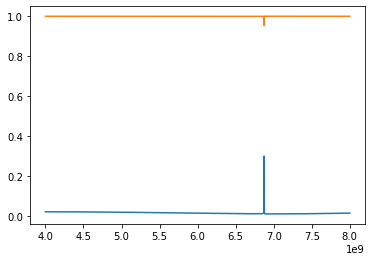

In [9]:
f = np.linspace(4e9, 8e9, 8001)
s11 = sample.get_s21('p1', 'p1', f)
s21 = sample.get_s21('p1', 'p2', f)
from matplotlib import pyplot as plt
plt.plot(f, np.abs(s11))
plt.plot(f, np.abs(s21))

In [10]:
sys, connections, elements_ = sample.get_tls()
f, delta, modes = sys.get_modes()
(f/(2*np.pi*1e9))[:3], (delta/(2*np.pi*1e6))[:3]

(array([ 7.94900285,  8.03741251, 16.16536276]),
 array([1.10372965e+04, 9.84372738e-02, 1.09699390e+04]))

In [13]:
elements_

{'chip_edge_ground': [],
 'p1': [Port p1],
 'p2': [Port p2],
 'TL-resonator coupler': [TL TL-resonator coupler (n=3)],
 'closed end resonator fanout': [TL closed end resonator fanout_group1 (n=2),
  TL closed end resonator fanout_group2 (n=1)],
 'cl1': [[R cl10, TL cl1 (n=1)]],
 'left TL': [TL left TL (n=1)],
 'closed end': [TL closed end (n=1)],
 'open end resonator fanout': [TL open end resonator fanout_group0 (n=1),
  TL open end resonator fanout_group1 (n=2)],
 'cl2': [[R cl20, TL cl2 (n=1)]],
 'right TL': [TL right TL (n=1)],
 'resonator ground': [Short ],
 'Coaxmon': [Short , C , C , C , C , C ],
 'left resonator end': [TL left resonator end (n=1)]}

In [14]:
connections

{(CPWCoupler "TL-resonator coupler", n=3, l=299.798, 'port1', 0): 1,
 (RectFanout closed end resonator fanout, n=3, grouping=(0, 2), 'wide', 0): 1,
 (CPWCoupler "TL-resonator coupler", n=3, l=299.798, 'port1', 1): 2,
 (RectFanout closed end resonator fanout, n=3, grouping=(0, 2), 'wide', 1): 2,
 (CPWCoupler "TL-resonator coupler", n=3, l=299.798, 'port1', 2): 3,
 (RectFanout closed end resonator fanout, n=3, grouping=(0, 2), 'wide', 2): 3,
 (RectFanout closed end resonator fanout, n=3, grouping=(0, 2),
  'center',
  0): 4,
 (RectGrounding cl1, 'wide', 0): 4,
 (RectFanout closed end resonator fanout, n=3, grouping=(0, 2),
  'center',
  1): 5,
 (RectGrounding cl1, 'wide', 1): 5,
 (CPW "left TL", l=968.634, 'port1', 0): 6,
 (<QCreator.elements.pad.Pad at 0x256cb2065e0>, 'port', 0): 6,
 (CPW "left TL", l=968.634, 'port2', 0): 7,
 (RectGrounding cl1, 'narrow', 0): 7,
 (CPW "closed end", l=2528.237, 'port1', 0): 8,
 (RectFanout closed end resonator fanout, n=3, grouping=(0, 2), 'up', 0): 8,


In [27]:
sys, connections, elements_ = sample.get_tls()
f, delta, modes = sys.get_modes()
f/(2*np.pi), delta/(2*np.pi)

{}
{}
{'port': 6}
{'port': 14}
{('port1', 0): 1, ('port1', 1): 2, ('port1', 2): 3, ('port2', 0): 9, ('port2', 1): 10, ('port2', 2): 11}
{('wide', 0): 1, ('wide', 1): 2, ('wide', 2): 3, ('center', 0): 4, ('center', 1): 5, 'up': 8}
{('wide', 0): 4, ('wide', 1): 5, 'narrow': 7}
{'port1': 6, 'port2': 7}
{'port1': 8, 'port2': 16}
{('wide', 0): 9, ('wide', 1): 10, ('wide', 2): 11, 'down': 18, ('center', 0): 12, ('center', 1): 13}
{('wide', 0): 12, ('wide', 1): 13, 'narrow': 15}
{'port1': 14, 'port2': 15}
{'wide': 16}
{'coupler0': 19, 'coupler1': 17, 'coupler2': 20, 'coupler3': 21, 'coupler4': 22, 'flux line': 23, 'qubit': 24}
{'port1': 17, 'port2': 18}


(array([7.18371249e+09, 7.18383843e+09, 7.94900310e+09, 1.61653661e+10,
        2.37487038e+10, 2.47789667e+10, 3.14891872e+10, 3.23923202e+10,
        3.33870611e+10, 3.48422547e+10, 3.73518747e+10, 3.75804931e+10,
        3.93131562e+10, 4.20360337e+10, 4.24436626e+10, 4.24909657e+10,
        4.32800530e+10, 4.33679938e+10, 5.44704061e+10, 6.50359478e+10,
        7.05138807e+10, 8.52250967e+10, 9.44639106e+10, 9.58087572e+10,
        1.05738449e+11, 1.05884562e+11, 1.05885496e+11, 1.07819354e+11,
        1.07821514e+11, 1.08771844e+11, 1.08771978e+11, 1.09359948e+11,
        1.09360105e+11, 1.38876037e+11, 1.40985336e+11, 1.69999374e+11,
        1.77599636e+11, 1.84689474e+11, 2.04620076e+11, 2.25388205e+11,
        2.27902529e+11, 2.35404884e+11, 2.35534913e+11, 2.37636196e+11,
        2.37726270e+11, 2.41173990e+11, 2.41189115e+11, 2.42237602e+11,
        2.42297581e+11, 2.45516637e+11, 2.46936734e+11, 2.49383812e+11,
        2.65942051e+11, 2.78891696e+11, 2.79488128e+11, 2.845943

In [22]:
modes[0,:]

array([ 4.00502037e-05-2.95712172e-05j, -3.74064506e-05+3.26282195e-05j,
        6.30446789e-05-2.20576009e-05j,  5.59667352e-05-1.90510189e-08j,
       -1.64016735e-02+4.79665245e-08j, -6.42361125e-05-1.93922803e-05j,
       -5.41057500e-05+1.94052917e-08j, -1.80306878e-02+1.87526309e-07j,
        4.45385623e-05-2.23011104e-05j,  0.00000000e+00+0.00000000e+00j,
       -1.62099252e-02+4.74071314e-08j,  0.00000000e+00+0.00000000e+00j,
        4.44989133e-05-2.23789737e-05j,  0.00000000e+00+0.00000000e+00j,
       -1.82164331e-02+1.87738089e-07j,  0.00000000e+00+0.00000000e+00j,
       -4.65688678e-05-1.91429522e-05j, -4.66003190e-05-1.90629765e-05j,
       -6.37803247e-01+1.61894630e-07j, -2.44349381e-02+1.91474195e-07j,
       -5.44047490e-01+1.38096469e-07j, -5.41933031e-01+1.37559793e-07j,
       -8.01004075e-07+5.91424343e-07j,  7.48129012e-07-6.52564390e-07j,
        8.89620325e-07-4.46002426e-07j, -3.53777176e-07-1.80894014e-04j,
        1.75112709e-09+6.10995766e-04j, -9.08485362

In [24]:
sys.elements

[Port p1,
 Port p2,
 TL TL-resonator coupler (n=3),
 TL closed end resonator fanout_group1 (n=2),
 TL closed end resonator fanout_group2 (n=1),
 R cl10,
 TL cl1 (n=1),
 TL left TL (n=1),
 TL closed end (n=1),
 TL open end resonator fanout_group0 (n=1),
 TL open end resonator fanout_group1 (n=2),
 R cl20,
 TL cl2 (n=1),
 TL right TL (n=1),
 Short ,
 Short ,
 L ,
 C ,
 C ,
 C ,
 C ,
 C ,
 C ,
 C ,
 TL left resonator end (n=1)]